In [ ]:
%load_ext autoreload
%autoreload 2

from tasks.MCQA.mcqa import MCQA_task, sample_answerable_question
causal_model = MCQA_task.causal_models["positional"]
import random, copy
from neural.pipeline import LMPipeline
from causal.counterfactual_dataset import CounterfactualDataset
from experiments.filter_experiment import FilterExperiment
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Qwen/Qwen2.5-0.5B"
model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
pipeline = LMPipeline(model_name, max_new_tokens=1, device=device, dtype=torch.float16, max_length=32)
pipeline.tokenizer.padding_side = "left"

def checker(neural_output, causal_output):
    return causal_output in neural_output["string"] or neural_output["string"] in causal_output

size = 64
counterfactual_datasets = MCQA_task.create_datasets(size)
test_counterfactual_datasets = MCQA_task.create_datasets(size)

# Filter the datasets based on model performance
print("\nFiltering datasets based on model performance...")
exp = FilterExperiment(pipeline, causal_model, checker)
filtered_datasets = exp.filter(counterfactual_datasets, verbose=True, batch_size=128)
test_filtered_datasets = exp.filter(test_counterfactual_datasets, verbose=True, batch_size=128)

token_positions = list(MCQA_task.create_token_positions(pipeline).values())

# Supervised Causal Variable Localization 

In the third notebook, we performed interchange interventions on the residual stream of a language model and then used our hypothesized causal model to interpret the results and localize the causal variables. While these experiments were revealing, intervening on the entire residual stream vector is a crude operation that lacks the surgical precision needed for a fine-grained analysis. A core capability of this code base is training loops that are set up to **use the hypothesized causal model as a source of supervision** for deciding where to perform interventions. 

First, we will show how Distributed Alignment Search (DAS) can be used to learn a linear subspace of the residual stream that contains a causal variable. Second, we will use Desiderata-Based Masking to localize the attention heads that carry over the answer position variable and the answer itself.

## Learning Linear Features with Distributed Alignment Search (DAS)

Our interchange intervention experiments in the third notebook indicated that the residual stream of the last token at layer 15 approximately contains the answer position variable. However, full vector patching is a crude instrument. A more surgical approach would be to intervene upon **features** of the resisual stream instead. We will learn a set of orthogonal linear features that form a subspace of the residual stream.  

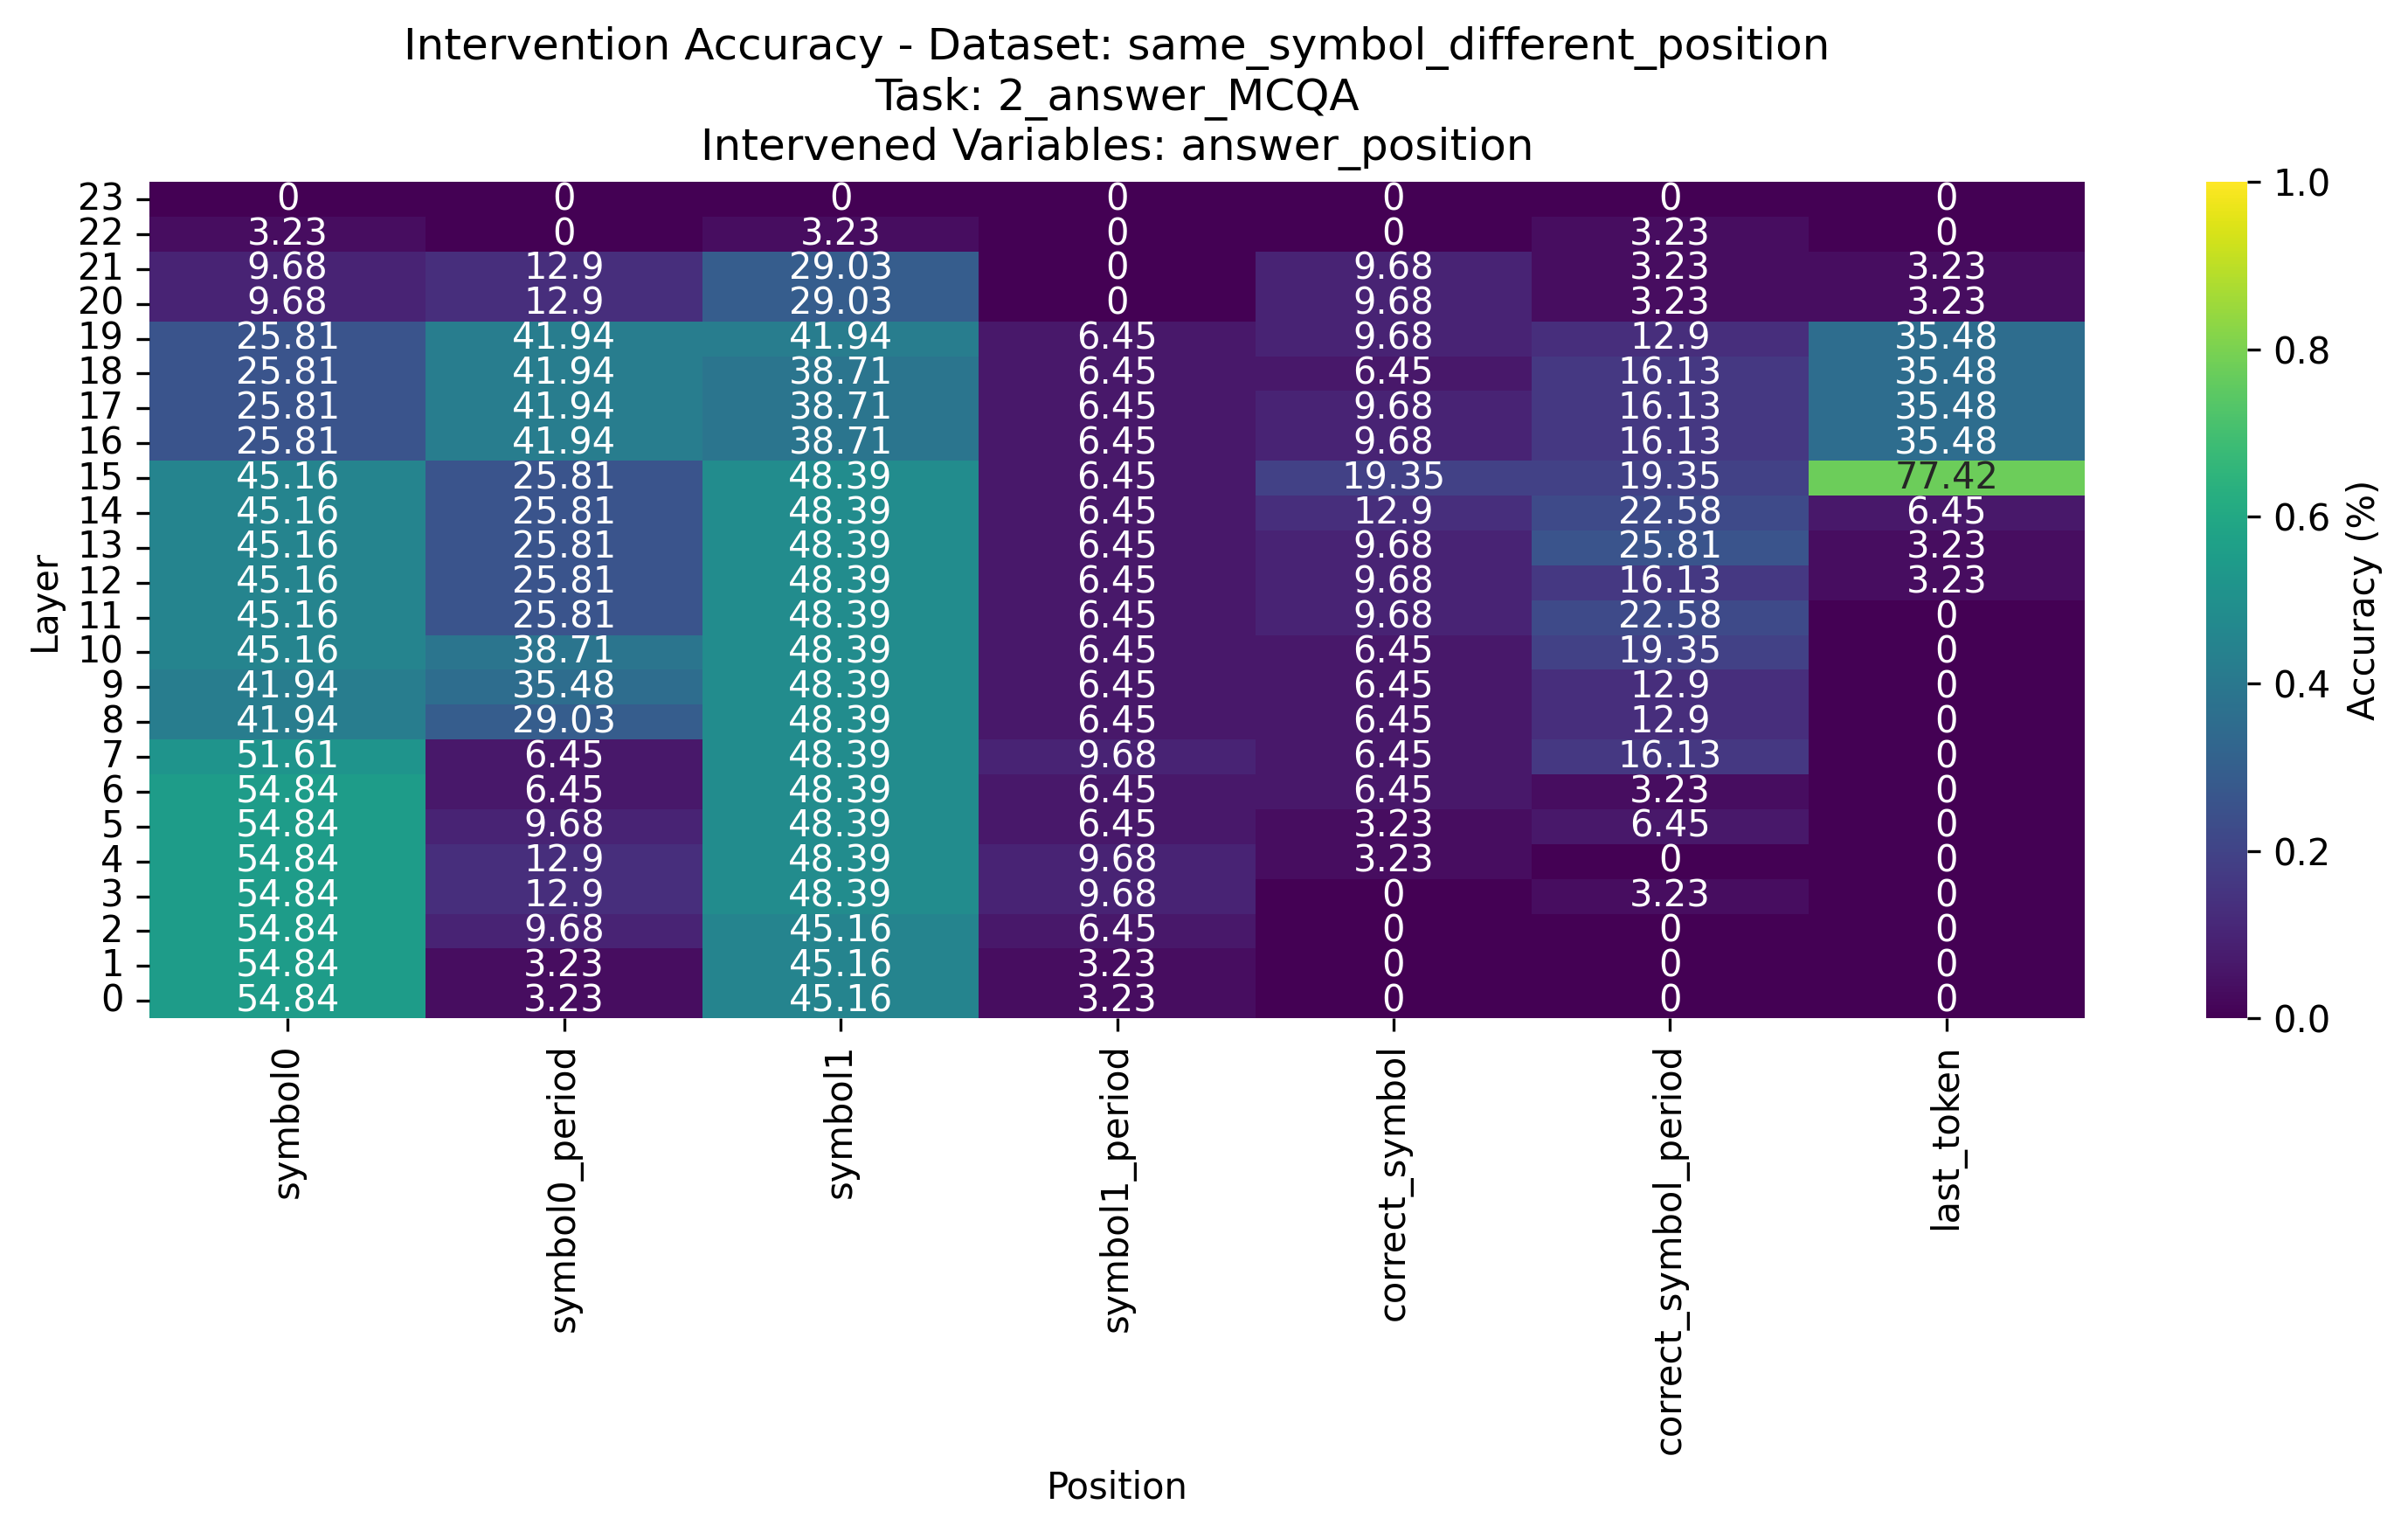

In [ ]:
from IPython.display import display, Image

display(Image(filename="vector_patching_results/heatmap_dataset_same_symbol_different_position_task_2_answer_MCQA_variables_answer_position.png"))


For each token position and model layer we train a set of 16 orthogonal linear features to realize the answer_position variable in the causal model. 
We again perform interchange interventions on the causal model and the language model, but we will now use the output of the causal model under intervention as a source of supervision to learn where to intervene in the language model. 
Instead of intervening on the full residual stream vector of the language model, we intervene on a linear subspace that is parameterized using 16 orthogonal vectors. 
Then we update these orthogonal vectors such that the output of the LM under interchange intervention is the same as the output of the causal model wtih an interchange intervention on the answer position variable.

In [ ]:
from experiments.LM_experiments.residual_stream_experiment import PatchResidualStream

config = {
    "batch_size": 64, 
    "evaluation_batch_size": 128, 
    "training_epoch": 4, 
    "n_features": 16, 
}
start = 0
end = pipeline.get_num_layers()
target_variables_list  = [["answer"], ["answer_position"]]
results_dir = "DAS_results"

token_positions = MCQA_task.create_token_positions(pipeline)

experiment = PatchResidualStream(pipeline, MCQA_task.causal_models["positional"], list(range(start, end)), list(token_positions.values()), checker, config=config)
experiment.train_interventions(filtered_datasets["same_symbol_different_position"], ["answer_position"], method="DAS", verbose=True)
raw_results = experiment.perform_interventions(filtered_datasets["same_symbol_different_position"], verbose=False, target_variables_list=target_variables_list, save_dir=results_dir)

Training [[AtomicModelUnit(id='ResidualStream(Layer-0,Token-symbol0)')]]...:   0%|          | 0/4 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7cb9e6b7f5e0>>
Traceback (most recent call last):
  File "/mnt/polished-lake/home/atticus/.cache/pypoetry/virtualenvs/causal-abstraction-5z8AXW-K-py3.10/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


## Held-Out Test Set Evaluation

DAS uses stoichastic gradient descent to search for a linear representation that satisfies causal properties expressed in the form of causal models and counterfactual datasets used for activation patching. Crucially, this puts us into a typical machine learning setting where **generalization** of the learned solution is essential. Causal variables found by DAS can be **overfit** to the training data, and provide a weaker signal when evaluated on held-out test data.

Observe below how the heatmap for test data shows weaker results than the train data heatmap, and these examples are generated in the exact same way.

In [ ]:
raw_test_results = experiment.perform_interventions(test_filtered_datasets["same_symbol_different_position"], verbose=False, target_variables_list=target_variables_list, save_dir=results_dir)

## Three Stages of Retrieval

The test results show three stages of retrieval with positional information. The causal variable is best localized at layer 15, with a weaker signal for the next four layers and then an even weaker signal for two layers. We can only see the first two stages in the full vector patching results!

The training results are spiky and more difficult to interpret, in contrast to the smooth gradation in the test results. This is clearly due to overfitting on a small dataset, which can be improved upon with more data.

TRAINING DATASETS RESULTS
DAS_results/heatmap_dataset_same_symbol_different_position_task_2_answer_MCQA_variables_answer_position.png


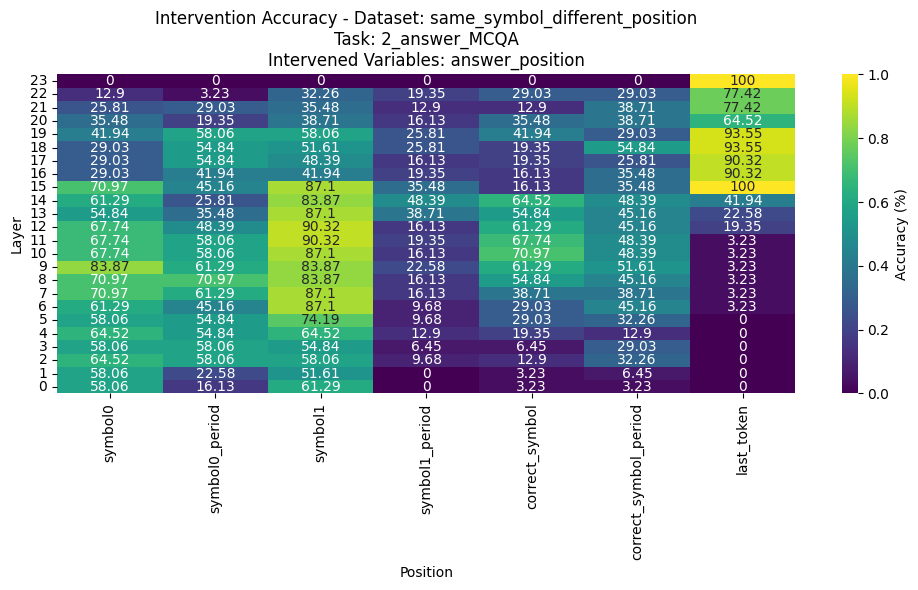

TEST DATASETS RESULTS
test_DAS_results/heatmap_dataset_null_task_2_answer_MCQA_variables_answer_position.png


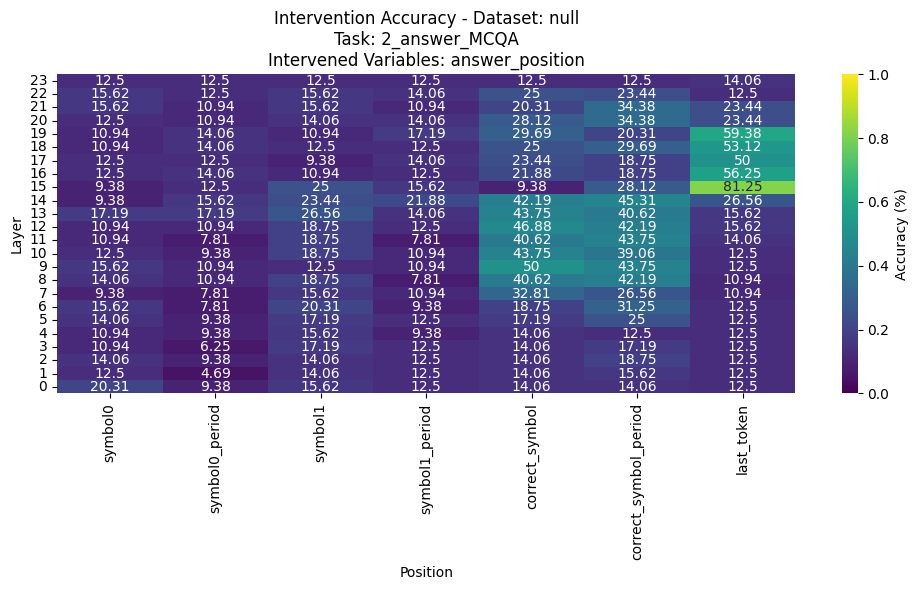

In [ ]:
print("TRAINING DATASETS RESULTS")
experiment.plot_heatmaps(raw_results, ["answer_position"], save_path=results_dir)
print("TEST DATASETS RESULTS")
experiment.plot_heatmaps(raw_test_results, ["answer_position"], save_path="test_" + results_dir)

We can see these three stages in the full vector patching results with the different symbol counterfactuals evaluated on the answer variable:

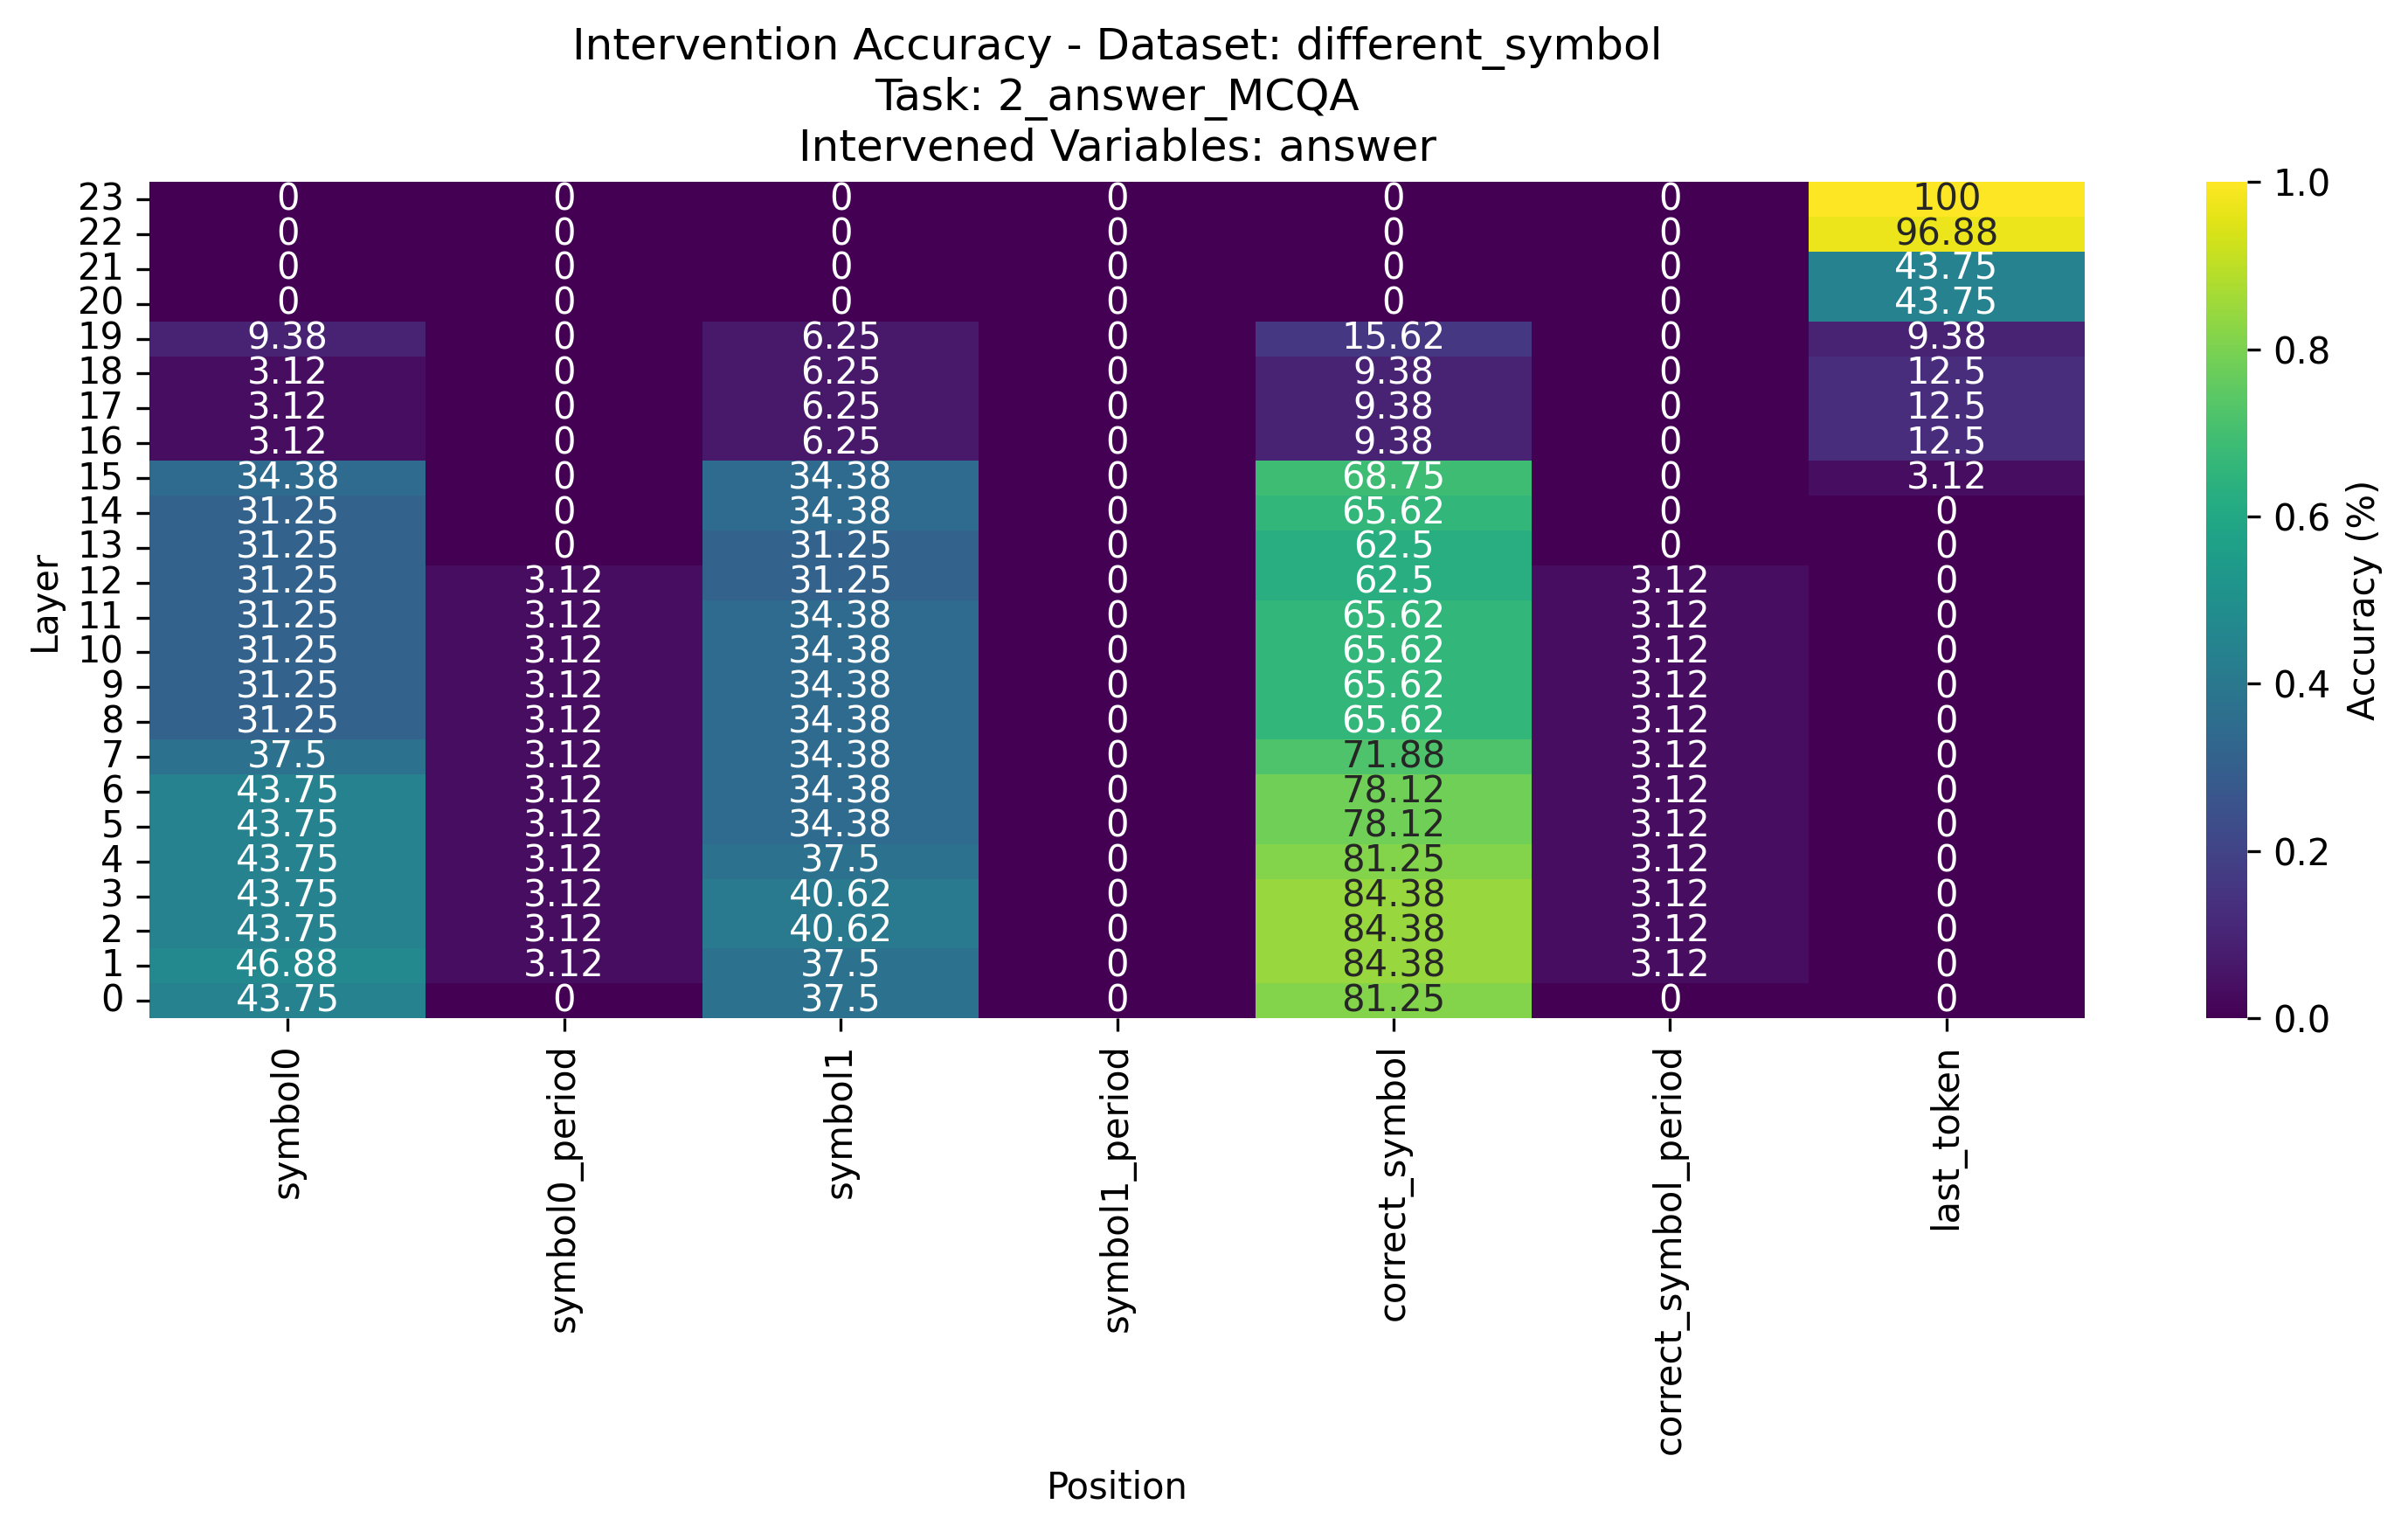

In [ ]:
from IPython.display import display, Image

display(Image(filename="vector_patching_results/heatmap_dataset_different_symbol_task_2_answer_MCQA_variables_answer.png"))


## Finding the Attention Heads that Bring in the Answer

Logically, there must be attention heads that are responsible for this movement. We will now train binary masks over attention head outputs that select which head outputs are targeted for interchange intervention, using the answer variable as a signal. This is called Desiderata-Based Masking (DBM). During training, the masks are continuous valued and a temperature term is annealed to make them converge to binary values. During testing, binary values are used. 

We train the masks to identify the heads that bring over the answer, then we print the accuracy on test data and the value of the binary masks. The 

Observe that the attention heads that bring over the answer variable correspond to exactly the three stages of computation we identified with our residual patching results. 

In [1]:
%load_ext autoreload
%autoreload 2

from tasks.MCQA.mcqa import MCQA_task, sample_answerable_question
causal_model = MCQA_task.causal_models["positional"]
import random, copy
from neural.pipeline import LMPipeline
from causal.counterfactual_dataset import CounterfactualDataset
from experiments.filter_experiment import FilterExperiment
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "Qwen/Qwen2.5-0.5B"
pipeline = LMPipeline(model_name, max_new_tokens=1, device=device, dtype=torch.bfloat16, max_length=32)
pipeline.tokenizer.padding_side = "left"

def checker(neural_output, causal_output):
    return causal_output in neural_output["string"] or neural_output["string"] in causal_output

size = 64
counterfactual_datasets = MCQA_task.create_datasets(size)
test_counterfactual_datasets = MCQA_task.create_datasets(size)

# Filter the datasets based on model performance
print("\nFiltering datasets based on model performance...")
exp = FilterExperiment(pipeline, causal_model, checker)
filtered_datasets = exp.filter(counterfactual_datasets, verbose=True, batch_size=128)
test_filtered_datasets = exp.filter(test_counterfactual_datasets, verbose=True, batch_size=128)

token_positions = list(MCQA_task.create_token_positions(pipeline).values())

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.

Filtering datasets based on model performance...


Filtering different_symbol: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


Dataset 'different_symbol': kept 17/64 examples (26.6%)


Filtering same_symbol_different_position: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


Dataset 'same_symbol_different_position': kept 29/64 examples (45.3%)


Filtering random_counterfactual: 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Dataset 'random_counterfactual': kept 19/64 examples (29.7%)

Total filtering results:
Original examples: 192
Kept examples: 65
Overall keep rate: 33.9%


Filtering different_symbol: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


Dataset 'different_symbol': kept 24/64 examples (37.5%)


Filtering same_symbol_different_position: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


Dataset 'same_symbol_different_position': kept 30/64 examples (46.9%)


Filtering random_counterfactual: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

Dataset 'random_counterfactual': kept 22/64 examples (34.4%)

Total filtering results:
Original examples: 192
Kept examples: 76
Overall keep rate: 39.6%


In [ ]:
from experiments.LM_experiments.attention_head_experiment import PatchAttentionHeads
from neural.LM_units import get_all_tokens, TokenPosition


results_dir = "DBM_results/"
num_heads = pipeline.get_num_attention_heads()
end = pipeline.get_num_layers()
target_variables_list  = [["answer"], ["answer_position"]]
config = {
    "learning_rate": 0.001,
    "batch_size": 32, 
    "evaluation_batch_size": 128, 
    "training_epoch": 20, 
    "masking":{
        "regularization_coefficient": 0.1,
    },
    "featurizer_kwargs": {
        "tie_masks": True
    }
}

all_tokens = TokenPosition(lambda x: get_all_tokens(x, pipeline), pipeline, id="all_tokens")

heads_masking = [[(layer, head) for layer in range(0, end) for head in range(num_heads)]]
heads_patching =  [[(layer, head)] for layer in range(end-2, end) for head in range(num_heads)]

experiment = PatchAttentionHeads(pipeline, causal_model, heads_masking, all_tokens, checker, config=config)
    
experiment.train_interventions(filtered_datasets["different_symbol"], ["answer"], method="DBM", verbose=True)
raw_results = experiment.perform_interventions(filtered_datasets["different_symbol"], verbose=True, target_variables_list=target_variables_list, save_dir=results_dir)
test_raw_results = experiment.perform_interventions(test_filtered_datasets["different_symbol"], verbose=True, target_variables_list=target_variables_list, save_dir="test_" + results_dir)
print("TEST PERFORMANCE")
experiment.plot_mask_heatmap(raw_results, save_path=results_dir)

Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:   5%|▌         | 1/20 [00:02<00:49,  2.59s/it]

Epoch 0: loss=35.6937, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  10%|█         | 2/20 [00:05<00:45,  2.51s/it]

Epoch 1: loss=35.4895, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  15%|█▌        | 3/20 [00:07<00:42,  2.52s/it]

Epoch 2: loss=35.2349, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  20%|██        | 4/20 [00:10<00:41,  2.58s/it]

Epoch 3: loss=34.9077, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  25%|██▌       | 5/20 [00:12<00:38,  2.56s/it]

Epoch 4: loss=34.4482, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  30%|███       | 6/20 [00:15<00:35,  2.54s/it]

Epoch 5: loss=33.7976, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  35%|███▌      | 7/20 [00:17<00:33,  2.55s/it]

Epoch 6: loss=32.7535, accuracy=0.2353, token_accuracy=0.2353


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  40%|████      | 8/20 [00:20<00:30,  2.57s/it]

Epoch 7: loss=30.8952, accuracy=0.2941, token_accuracy=0.2941


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  45%|████▌     | 9/20 [00:22<00:28,  2.55s/it]

Epoch 8: loss=26.5552, accuracy=0.2941, token_accuracy=0.2941


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  50%|█████     | 10/20 [00:25<00:25,  2.53s/it]

Epoch 9: loss=12.6393, accuracy=0.4118, token_accuracy=0.4118


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  55%|█████▌    | 11/20 [00:28<00:23,  2.57s/it]

Epoch 10: loss=2.4519, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  60%|██████    | 12/20 [00:30<00:20,  2.55s/it]

Epoch 11: loss=2.4128, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  65%|██████▌   | 13/20 [00:33<00:17,  2.54s/it]

Epoch 12: loss=2.4163, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  70%|███████   | 14/20 [00:35<00:15,  2.52s/it]

Epoch 13: loss=2.3959, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  75%|███████▌  | 15/20 [00:38<00:12,  2.55s/it]

Epoch 14: loss=2.4033, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  80%|████████  | 16/20 [00:40<00:10,  2.53s/it]

Epoch 15: loss=2.4010, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  85%|████████▌ | 17/20 [00:43<00:07,  2.53s/it]

Epoch 16: loss=2.3955, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  90%|█████████ | 18/20 [00:45<00:05,  2.57s/it]

Epoch 17: loss=2.4052, accuracy=0.8824, token_accuracy=0.8824


Training [[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='Attentio...:  95%|█████████▌| 19/20 [00:48<00:02,  2.55s/it]

Epoch 18: loss=2.3855, accuracy=0.8824, token_accuracy=0.8824


Epoch 19: loss=2.3775, accuracy=0.8824, token_accuracy=0.8824


Running interventions: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, dataset=different_symbol, units=[[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-1,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-2,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-3,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-4,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-5,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-6,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-7,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-8,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-9,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-10,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-11,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-12,Token

TEST PERFORMANCE


TypeError: unhashable type: 'list'

In [9]:

print(raw_results)

{'method_name': 'InterventionExperiment', 'model_name': 'Qwen2ForCausalLM', 'task_name': '2_answer_MCQA', 'dataset': {'different_symbol': {'model_unit': {"[[AtomicModelUnit(id='AttentionHead(Layer-0,Head-0,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-1,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-2,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-3,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-4,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-5,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-6,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-7,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-8,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-9,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-10,Token-all_tokens)'), AtomicModelUnit(id='AttentionHead(Layer-0,Head-11,Token-all_tokens)'), A